<a href="https://colab.research.google.com/github/Redzoro1993/LossModel/blob/master/LossMoldelR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
install.packages("actuar")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [44]:
install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [45]:
install.packages("univariateML")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [46]:
install.packages("VGAM")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [47]:
library(actuar)
library(tidyverse)
library(univariateML)
library(VGAM)

In [83]:
df = read.csv("/content/z_default_gses_zip.csv",
               header = TRUE)
str(df)

'data.frame':	1114171 obs. of  17 variables:
 $ id_loan     : chr  "F100Q1000050" "F100Q1000160" "F100Q1000161" "F100Q1000199" ...
 $ period      : chr  "10/01/02" "04/01/02" "08/01/02" "12/01/01" ...
 $ delq_sts    : chr  "R" "8" "R" "11" ...
 $ flag_mod    : chr  "" "" "" "" ...
 $ actual_loss : num  21157 NA -38030 NA 5276 ...
 $ lpi_date    : chr  "07/01/01" "07/01/01" "10/01/00" "12/01/00" ...
 $ zb_dte      : chr  "10/01/02" "04/01/02" "08/01/02" "12/01/01" ...
 $ upb_prior_zb: num  106217 37672 43273 107080 68930 ...
 $ src         : chr  "FR" "FR" "FR" "FR" ...
 $ cltv        : int  95 43 73 75 95 95 95 87 90 92 ...
 $ orig_upb    : int  107000 38000 44000 108000 69000 138000 138000 144000 88000 83000 ...
 $ ltv         : int  95 43 73 75 95 95 95 87 90 92 ...
 $ int_rt      : num  8.38 9 8.25 8.75 8.12 ...
 $ st          : chr  "TX" "MT" "IN" "KS" ...
 $ zipcode     : int  75000 59900 47300 66000 34700 98600 12500 97000 40000 28000 ...
 $ orig_trm    : int  360 360 360 360 360

In [84]:
sub_df = select(df, c("upb_prior_zb" , "src", "ltv" , "frst_dte"))
sub_df = sub_df[sub_df$src == "FR",]
sub_df = sub_df[sub_df$upb_prior_zb != 0,]
sub_df = na.omit(sub_df)

In [85]:
sub_df$LGD[sub_df$frst_dte <= "2006-01-01" & sub_df$ltv < 80] <- 30
sub_df$LGD[sub_df$frst_dte <= "2006-01-01" & sub_df$ltv >= 80] <- 40
sub_df$LGD[sub_df$frst_dte > "2006-01-01" & sub_df$ltv < 80] <- 35
sub_df$LGD[sub_df$frst_dte > "2006-01-01" & sub_df$ltv >= 80] <- 45
sub_df$loan_loss = sub_df$upb_prior_zb*(sub_df$LGD/100)

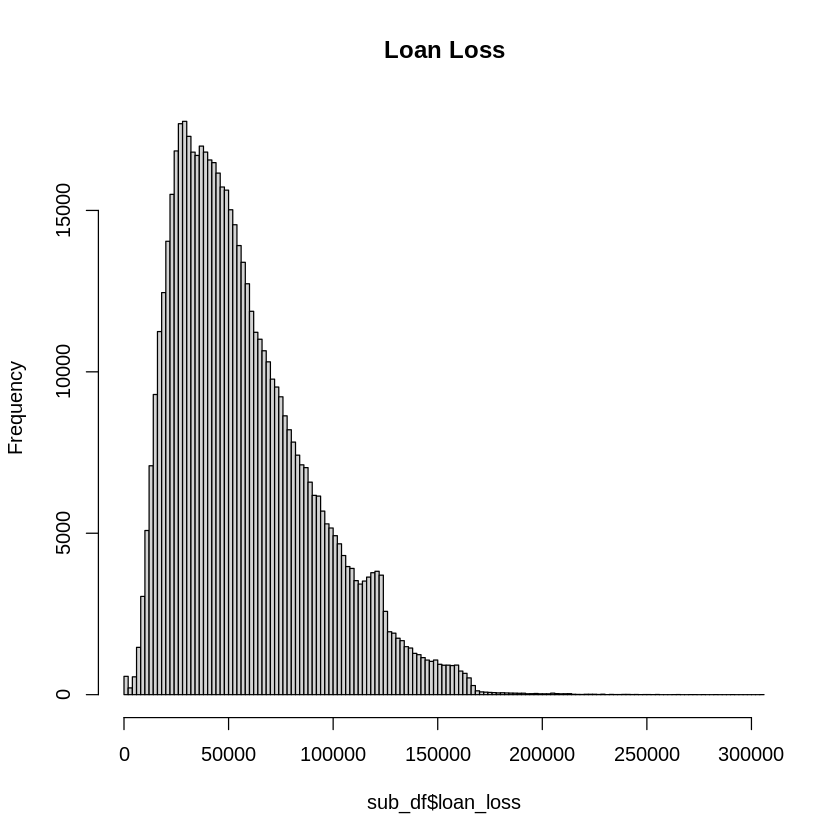

In [86]:
hist(sub_df$loan_loss, breaks = 200, main = "Loan Loss")

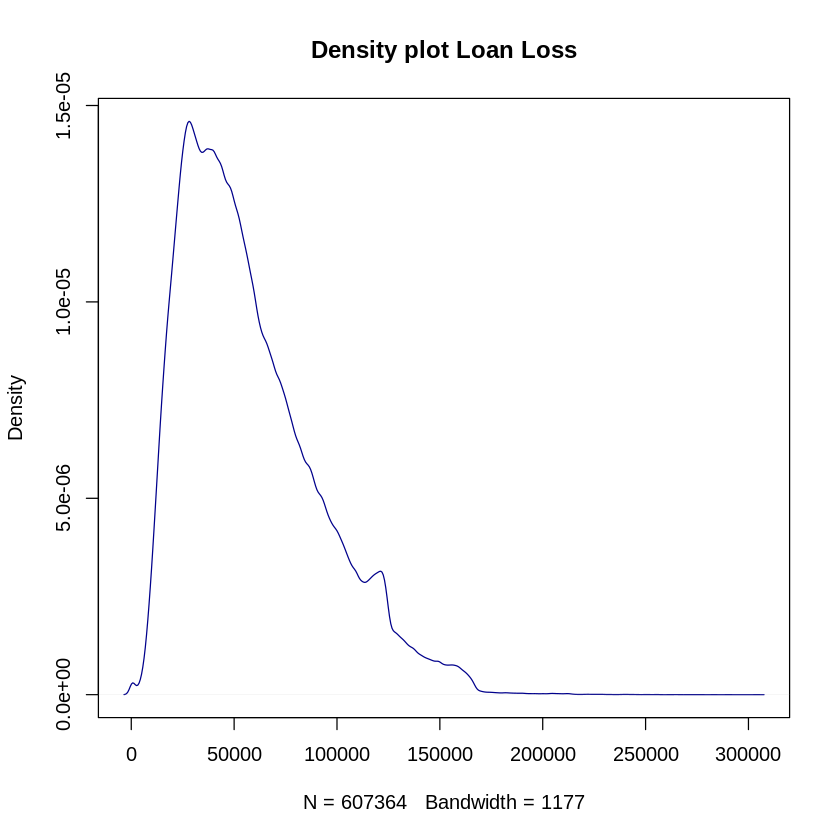

In [87]:
x = na.omit(sub_df$loan_loss)
d = density(x, bw = "sj")
plot(d, col = "darkblue", 
     main = "Density plot Loan Loss")

In [53]:
AIC = AIC(mllnorm(sub_df$loan_loss), mlexp(sub_df$loan_loss),
          mlgamma(sub_df$loan_loss),mlnorm(sub_df$loan_loss),
          mlpareto(sub_df$loan_loss),mlbetapr(sub_df$loan_loss),
          mlgumbel(sub_df$loan_loss),mlinvgamma(sub_df$loan_loss))

BIC = BIC(mllnorm(sub_df$loan_loss), mlexp(sub_df$loan_loss),
          mlgamma(sub_df$loan_loss),mlnorm(sub_df$loan_loss),
          mlpareto(sub_df$loan_loss),mlbetapr(sub_df$loan_loss),
          mlgumbel(sub_df$loan_loss),mlinvgamma(sub_df$loan_loss))

dist = c("Log-normal","Exponential","Gamma","Normal","Pareto","Beta","Gumbel",
         "invgamma")

AIC_BIC = data.frame(dist,AIC,BIC)
AIC_BIC

,dist,df,AIC,df.1,BIC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
mllnorm(sub_df$loan_loss),Log-normal,2,14288666,2,14288689
mlexp(sub_df$loan_loss),Exponential,1,14535545,1,14535557
mlgamma(sub_df$loan_loss),Gamma,2,14233214,2,14233237
mlnorm(sub_df$loan_loss),Normal,2,14370761,2,14370783
mlpareto(sub_df$loan_loss),Pareto,2,17733194,2,17733216
mlbetapr(sub_df$loan_loss),Beta,2,16181364,2,16181387
mlgumbel(sub_df$loan_loss),Gumbel,2,14249709,2,14249731
mlinvgamma(sub_df$loan_loss),invgamma,2,17002999,2,17003021


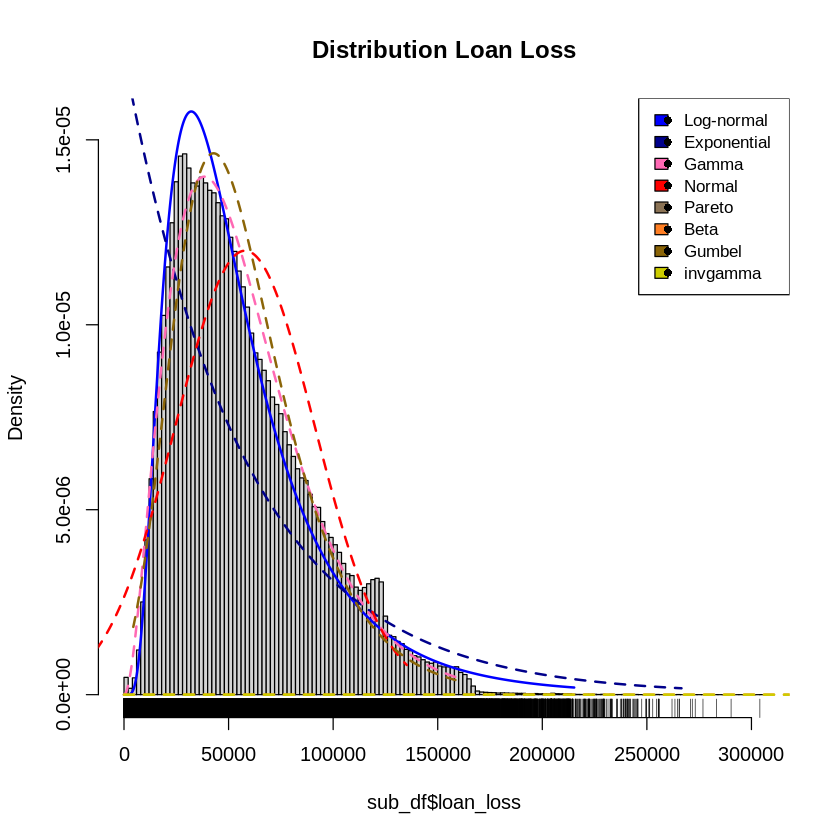

In [54]:
hist(sub_df$loan_loss,
     main = "Distribution Loan Loss",
     breaks = 200,
     freq = FALSE,
     ylim = c(0, 0.0000155),
     pch = 16
     )

lines(mllnorm(sub_df$loan_loss), lwd = 2, lty = 1, col = "blue")
lines(mlexp(sub_df$loan_loss), lwd = 2, lty = 2, col = "darkblue")
lines(mlgamma(sub_df$loan_loss), lwd = 2, lty = 2, col = "hotpink")
lines(mlnorm(sub_df$loan_loss), lwd = 2, lty = 2, col = "red")
lines(mlpareto(sub_df$loan_loss), lwd = 2, lty = 2, col = "burlywood4")
lines(mlbetapr(sub_df$loan_loss), lwd = 2, lty = 2, col = "chocolate1")
lines(mlgumbel(sub_df$loan_loss), lwd = 2, lty = 2, col = "darkgoldenrod4")
lines(mlinvgamma(sub_df$loan_loss), lwd = 2, lty = 2, col = "yellow3")

legend("topright", dist,
       fill=c("blue", "darkblue","hotpink","red","burlywood4","chocolate1",
              "darkgoldenrod4","yellow3"),cex = 0.85, pch = 16)
rug(sub_df$loan_loss)

### Parameters with MLE

In [55]:
MLE_g = mlgamma(sub_df$loan_loss)
MLE_n = mlnorm(sub_df$loan_loss)
MLE_par = mlpareto(sub_df$loan_loss)
MLE_exp = mlexp(sub_df$loan_loss)
MLE_log_n = mllnorm(sub_df$loan_loss)

In [56]:
MLE_g

Maximum likelihood estimates for the Gamma model 
    shape       rate  
2.983e+00  5.153e-05  

### pp - qq plots

In [57]:
dpts = sub_df$loan_loss
dpts = sort(dpts)

n = length(dpts)
x = (1 : n) / (n + 1)

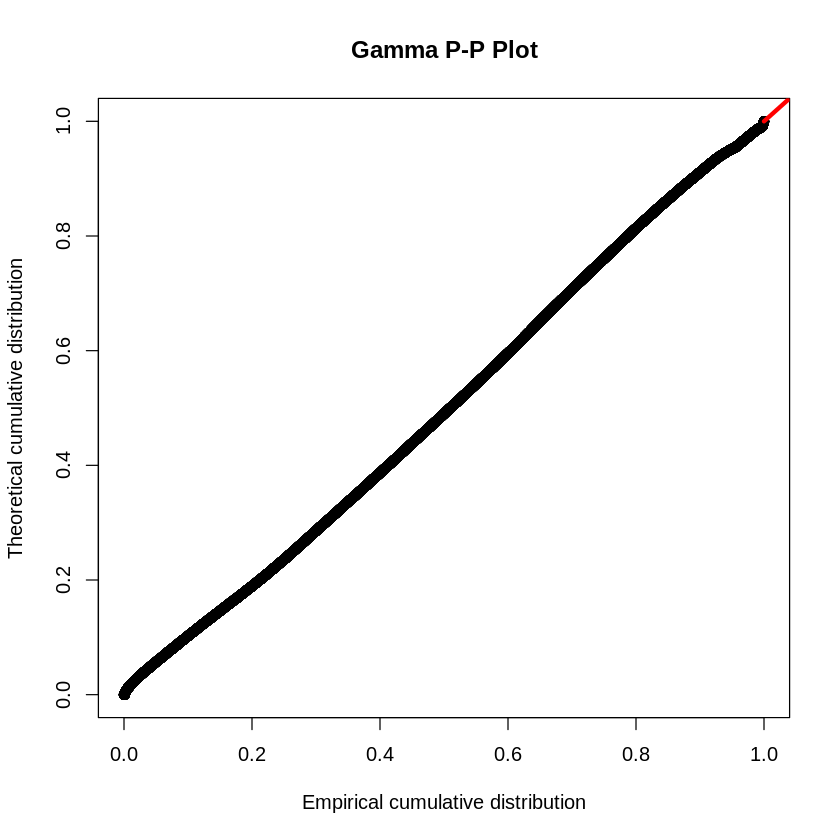

In [58]:
y <- pgamma(dpts, shape = MLE_g[1] , rate = MLE_g[2])
plot(x, y,main='Gamma P-P Plot',
     xlab='Empirical cumulative distribution',
     ylab='Theoretical cumulative distribution')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 3.5)

Warning message in log1p(-(scale/q)^shape):
“NaNs produced”


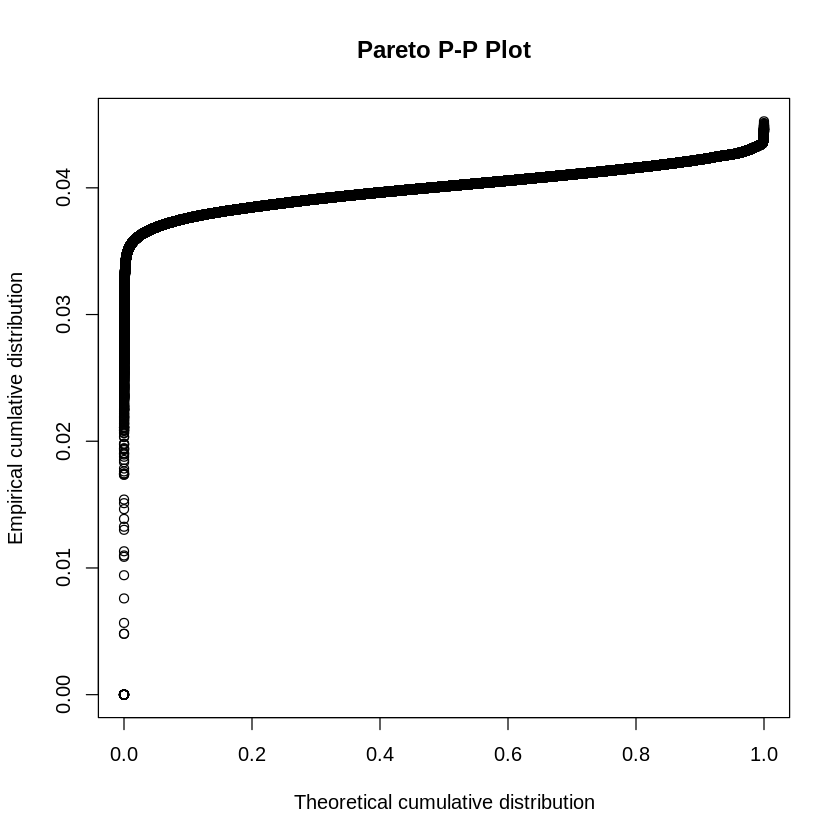

In [59]:
y <- ppareto(dpts,scale = MLE_par[1], shape = MLE_par[2])
plot(x, y,main='Pareto P-P Plot',
     xlab='Theoretical cumulative distribution',
     ylab='Empirical cumlative distribution')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 3.5)

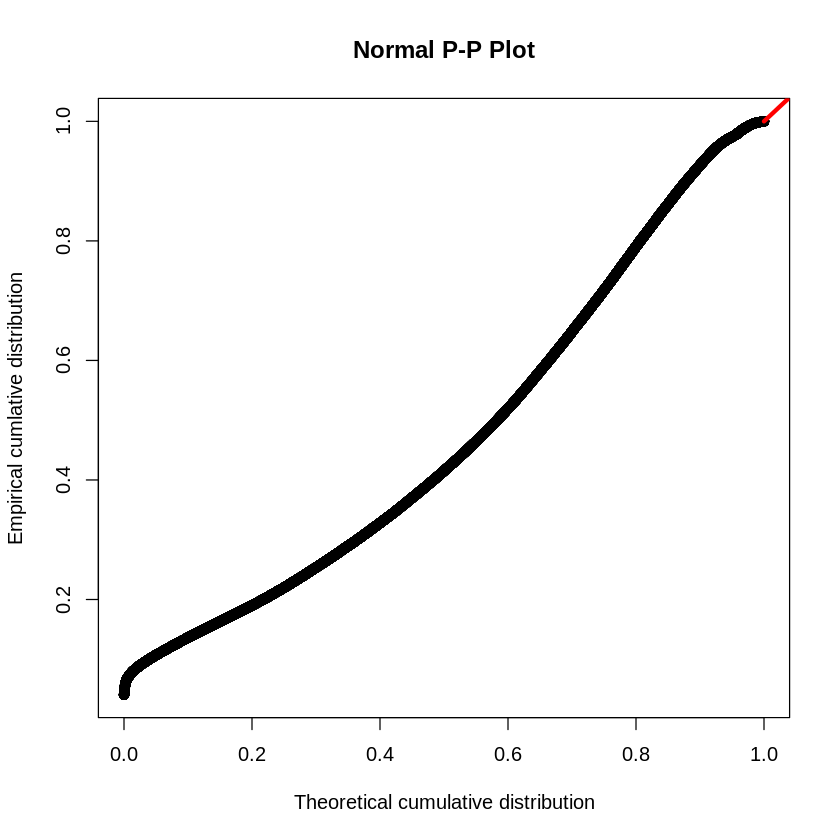

In [60]:
y <- pnorm(dpts, mean = MLE_n[1], sd = MLE_n[2] )
plot(x, y,main='Normal P-P Plot',
     xlab='Theoretical cumulative distribution',
     ylab='Empirical cumlative distribution')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 3.5)

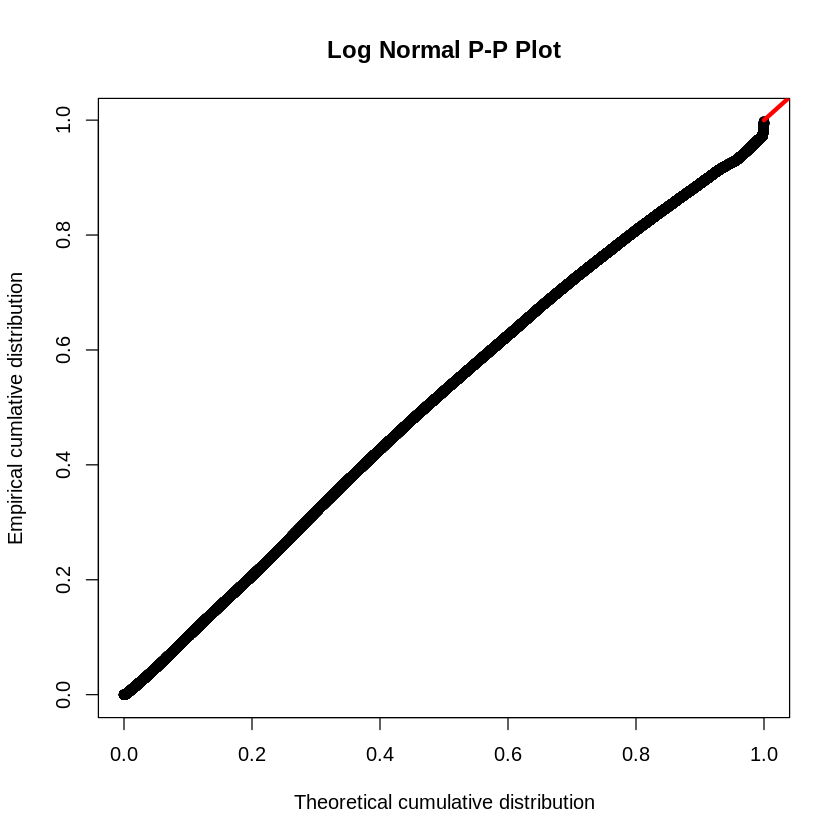

In [61]:
y <- plnorm(dpts, meanlog = MLE_log_n[1] , sdlog = MLE_log_n[2])
plot(x, y,main='Log Normal P-P Plot',
     xlab='Theoretical cumulative distribution',
     ylab='Empirical cumlative distribution')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 3.5)

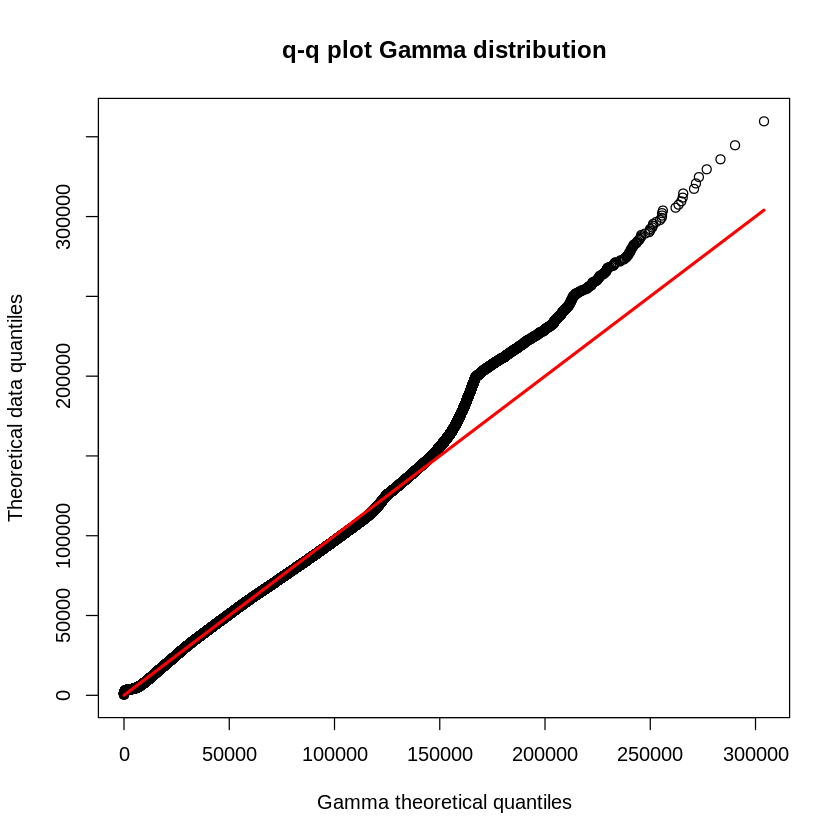

In [62]:
y_g = qgamma((1 : n) / (n + 1), shape = MLE_g[1], rate = MLE_g[2])

plot(dpts, y_g, main = "q-q plot Gamma distribution",
     xlab = 'Gamma theoretical quantiles',
     ylab = 'Theoretical data quantiles')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 2.5)

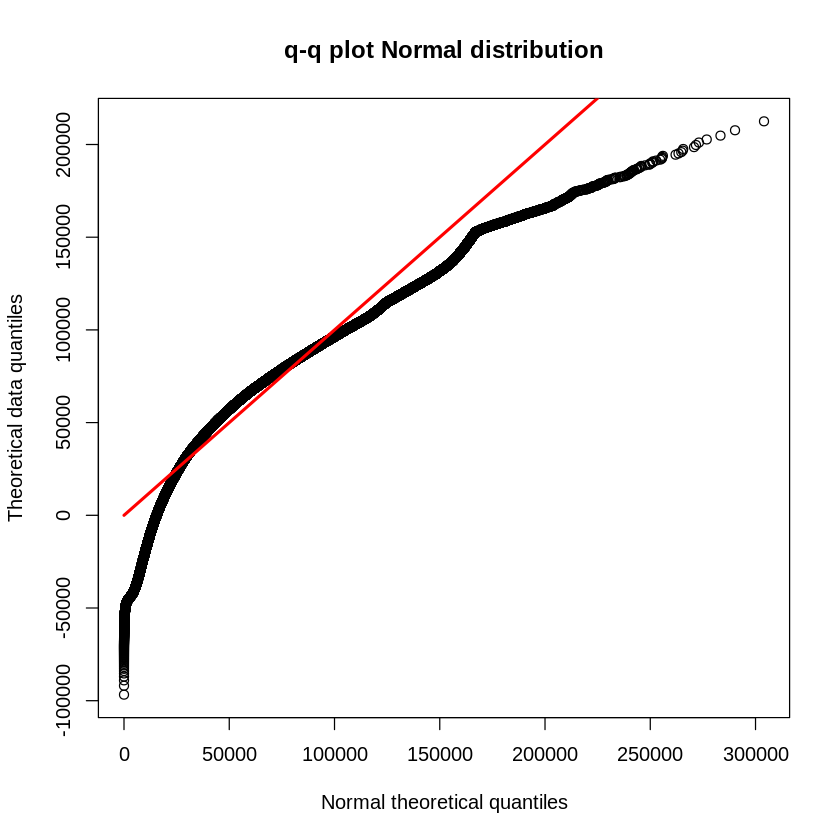

In [63]:
y_g = qnorm((1 : n) / (n + 1), mean = MLE_n[1], sd = MLE_n[2])

plot(dpts, y_g, main = "q-q plot Normal distribution",
     xlab = 'Normal theoretical quantiles',
     ylab = 'Theoretical data quantiles')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 2.5)

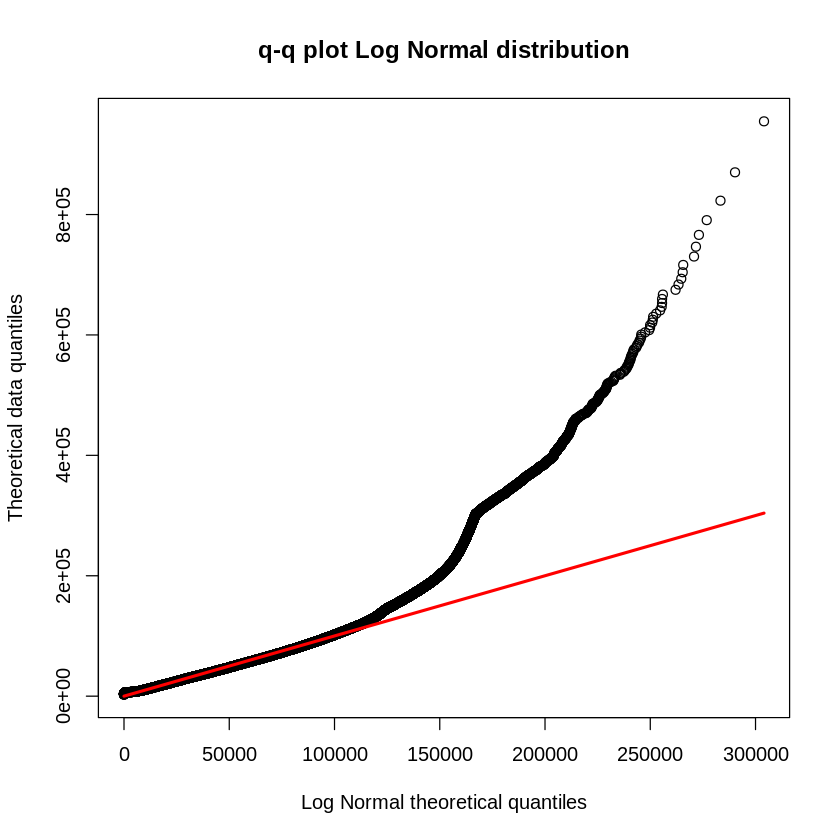

In [74]:
y_g = qlnorm((1 : n) / (n + 1),meanlog = MLE_log_n[1], sdlog = MLE_log_n[2])

plot(dpts, y_g, main = "q-q plot Log Normal distribution",
     xlab = 'Log Normal theoretical quantiles',
     ylab = 'Theoretical data quantiles')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 2.5)

In [65]:
MLE_par

Maximum likelihood estimates for the Pareto model 
      a        b  
0.06025  0.00300  

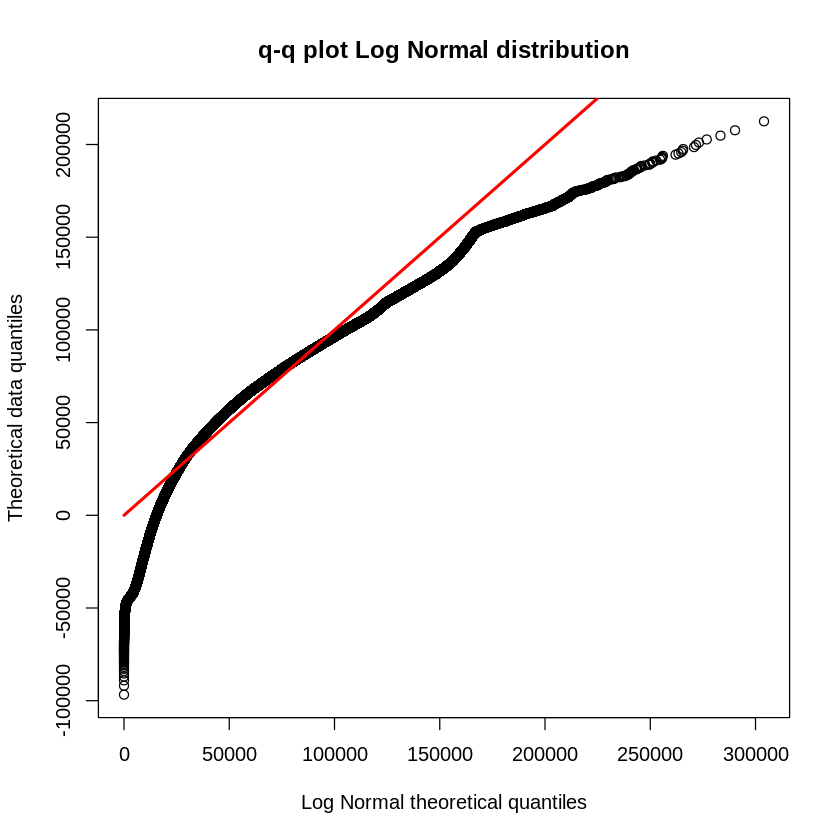

In [66]:
y = qlnorm((1 : n) / (n + 1), meanlog = MLE_log_n[1] , sdlog = MLE_log_n[2])

plot(dpts, y_g, main = "q-q plot Log Normal distribution",
     xlab = 'Log Normal theoretical quantiles',
     ylab = 'Theoretical data quantiles')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 2.5)

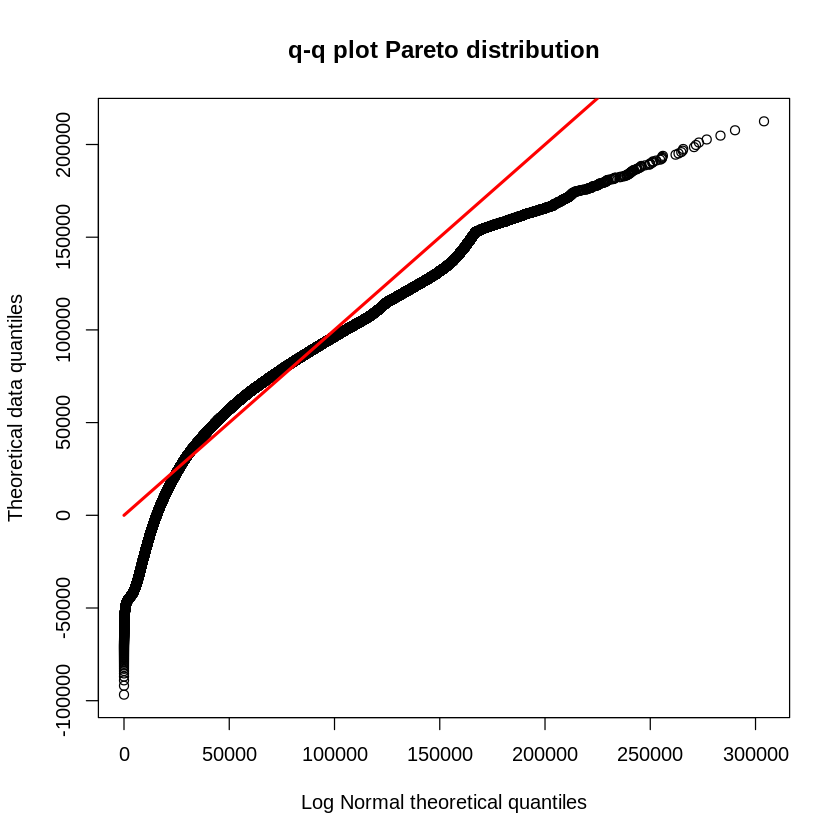

In [67]:
y = qpareto((1 : n) / (n + 1), scale = MLE_par[1] ,  shape = MLE_par[2])

plot(dpts, y_g, main = "q-q plot Pareto distribution",
     xlab = 'Log Normal theoretical quantiles',
     ylab = 'Theoretical data quantiles')
lines(1:ceiling(max(dpts)), 1:ceiling(max(dpts)) , col = "red" , lty = 1,
      lwd = 2.5)

### Mixture distributions

#### Gamma - Gamma

Break point

In [88]:
length(sub_df$loan_loss)

[1] 607364

In [89]:
body = sub_df[sub_df$loan_loss < 200000,]
length(body$loan_loss)

[1] 607005

In [91]:
tail = sub_df[sub_df$loan_loss >= 200000,]
length(tail$loan_loss)

[1] 359

In [144]:
brk_p = 200000

Parameters

In [100]:
b_gamma = mlgamma(body$loan_loss)
t_gamma = mlgamma(tail$loan_loss)

Mix function

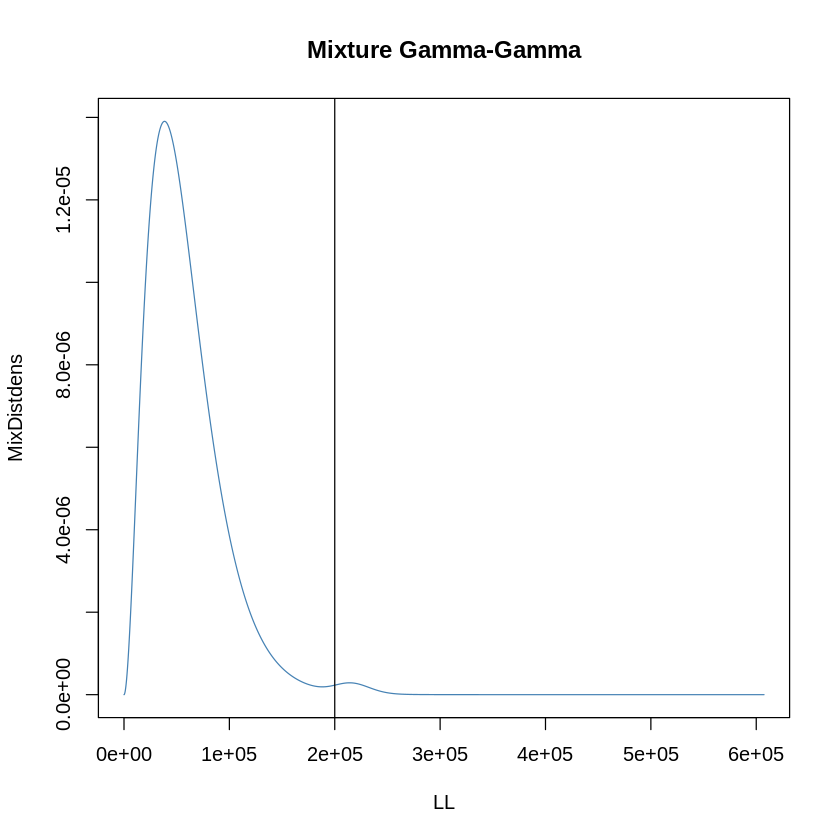

In [145]:
MixtDD = function(x, a1, a2, shapeg, rateg, shapeg2, rateg2){
  a1 * dgamma(x, shape = shapeg, rate = rateg) + 
  a2 * dgamma(x, shape = shapeg2, rate = rateg2)
}

LL = 1:length(sub_df$loan_loss)
a1 = 0.99 
a2 = 0.01
shapeg = b_gamma[1]
rateg = b_gamma[2]
shapeg2 = t_gamma[1]
rateg2 = t_gamma[2]

MixDistdens = MixtDD(LL, a1, a2,b_gamma[1], b_gamma[2],t_gamma[1], t_gamma[2])
                               
plot(LL, MixDistdens, type = "l",main = "Mixture Gamma-Gamma",col = "steelblue")
abline(v = brk_p)

In [112]:
MixtDD = function(x, a1, a2, shapeg, rateg, shapeg2, rateg2){
  a1 * dgamma(x, shape = shapeg, rate = rateg) + 
  a2 * dgamma(x, shape = shapeg2, rate = rateg2)
}

LL = 1:length(sub_df$loan_loss)
a1 = 0.99 
a2 = 0.01

MixDistdens = MixtDD(LL, a1, a2, b_gamma[1], b_gamma[2], t_gamma[1], t_gamma[2])
                               
plot(LL, MixDistdens, type = "l",main = "Mixture Gamma-Gamma",col = "steelblue")

[1] 607364

[1] 607364

Lognormal-pareto

In [123]:
b_lnl = mllnorm(body$loan_loss)
t_pa = mlpareto(tail$loan_loss)
b_lnl
t_pa

Maximum likelihood estimates for the Lognormal model 
meanlog    sdlog  
10.7883   0.6398  

Maximum likelihood estimates for the Pareto model 
        a          b  
    12.34  200068.48  

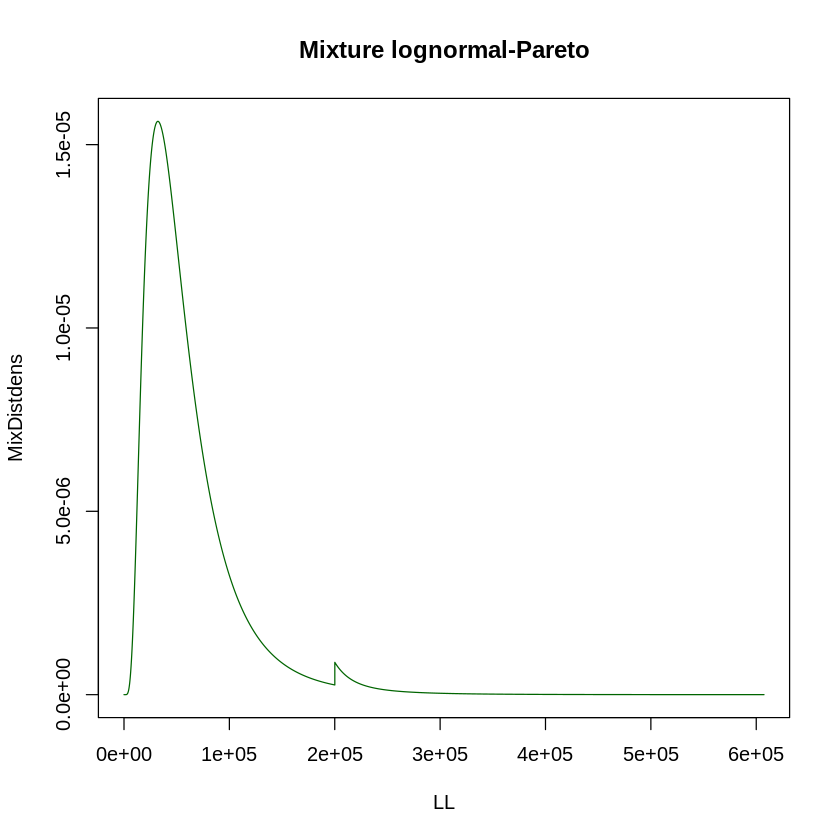

In [130]:
MixtDD2 = function(x, a1, a2, meanl, sdl, shapea, scaleb){
  a1 * dlnorm(x, meanlog = meanl, sdlog = sdl) + 
  a2 * dpareto(x, shape = shapea, scale = scaleb)
}

LL = 1:length(sub_df$loan_loss)
a1 = 0.99
a2 = 0.01

MixDistdens = MixtDD2(LL, a1, a2,b_lnl[1], b_lnl[2],t_pa[1], t_pa[2])
                               
plot(LL, MixDistdens, type = "l",main = "Mixture lognormal-Pareto",col = "darkgreen")

gamma - pareto

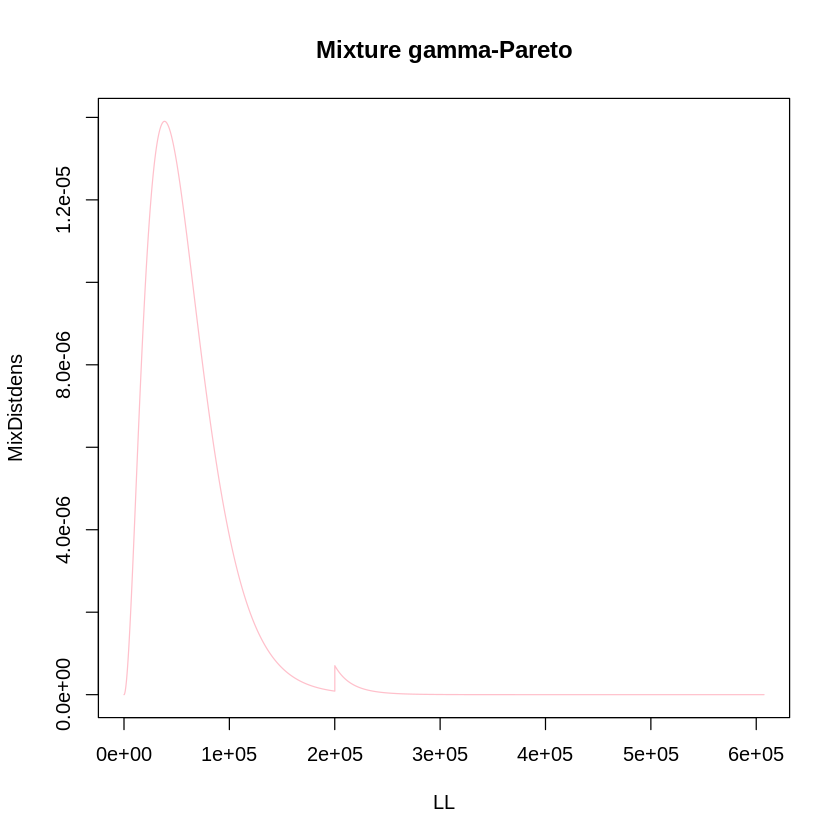

In [136]:
MixtDD3 = function(x, a1, a2, shapeg, rateg, shapea, scaleb){
  a1 * dgamma(x, shape = shapeg, rate = rateg) + 
  a2 * dpareto(x, shape = shapea, scale = scaleb)
}

LL = 1:length(sub_df$loan_loss)
a1 = 0.99
a2 = 0.01

MixDistdens = MixtDD3(LL, a1, a2, b_gamma[1], b_gamma[2],t_pa[1], t_pa[2])
                               
plot(LL, MixDistdens, type = "l",main = "Mixture gamma-Pareto",col = "pink")

Gamma - beta

In [142]:
t_be = mlbetapr(tail$loan_loss)
t_be

Maximum likelihood estimates for the BetaPrime model 
   shape1     shape2  
4.051e+07  1.872e+02  

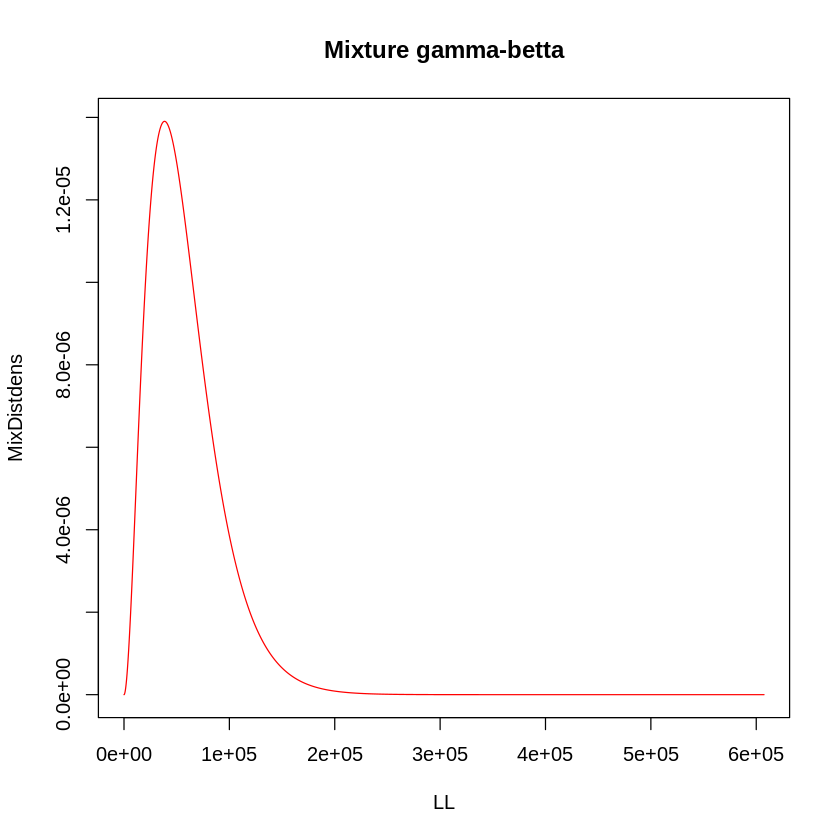

In [143]:
MixtDD4 = function(x, a1, a2, shapeg, rateg, shape1b, shape1b2){
  a1 * dgamma(x, shape = shapeg, rate = rateg) + 
  a2 * dbeta(x,shape1 = shapebt, shape2 = shapebt2)
}

LL = 1:length(sub_df$loan_loss)
a1 = 0.99
a2 = 0.01

MixDistdens = MixtDD3(LL, a1, a2, b_gamma[1], b_gamma[2],t_be[1], t_be[2])
                               
plot(LL, MixDistdens, type = "l",main = "Mixture gamma-betta",col = "red")